### Import PyTorch

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.7.1+cu128


### Create example dataset

In [3]:
weight = 0.7
bias = 0.3

start = 0 
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(f"Length of X: {len(X)}") 
print(f"Length of y: {len(y)}")
X[:5], y[:5]

Length of X: 50
Length of y: 50


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

### Split dataset into training and test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X,
                                   test_size=0.2,
                                   train_size=0.8,
                                   random_state=42,
                                   shuffle=False)
y_train, y_test = train_test_split(y,
                                   test_size=0.2,
                                   train_size=0.8,
                                   random_state=42,
                                   shuffle=False)

len(X_train), len(X_test), len(y_train), len(y_test) 

(40, 10, 40, 10)

### Visualize data

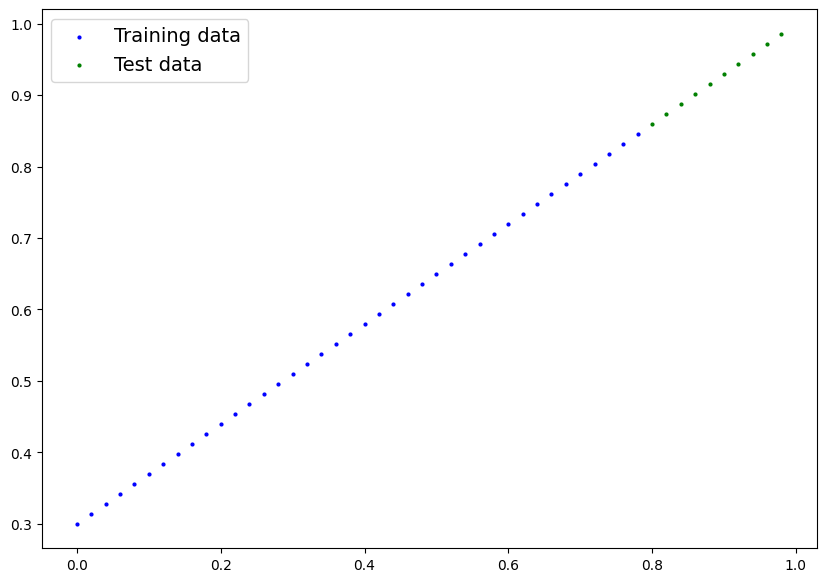

In [5]:
import matplotlib.pyplot as plt

# Plots training data, test data, and compares predictions
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size":14})

plot_predictions()

### PyTorch model building essentials

* `torch.nn` - contains all of the buildings for computational graphs (e.g. neural networks)
* `torch.nn.Parameter` - defines parameters for the model to learn and improve
* `torch.nn.Module` - base class for all neural network modules
* `torch.optim` - optimizers for gradient descent
* `def forward()` - defines what happens in the forward computation of the model, requires overriding   
for all `nn.Module` subclasses

##### Refer to https://docs.pytorch.org/docs/stable/ for documentation

### Linear Regression Model

In [15]:
""" 
What model does:
    1. Start with random values of weights and biases
    2. Look at training data and adjust the random values to get closer to ideal values through
        a. Gradient Descent (requires_grad=True)
        b. Backpropagation
"""

import torch
from torch import nn

# Create Linear Regression model class
class LinearRegressionModel(nn.Module):   # Inherits almost everything in PyTorch
    def __init__(self):
        super().__init__()
        
        # nn.Linear() creates linear model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # Forward method to define the computation in the model 
    # Any subclass of nn.module needs to override forward()
    def forward(self, x:torch.Tensor) -> torch.Tensor:   # x is the input data
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_lr = LinearRegressionModel()
model_lr.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

### Train LR Model

In [16]:
# Loss function
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(params=model_lr.parameters(),
                            lr=0.01)

# Number of epochs (loops)
epochs = 165

# Initialize empty lists to store values
epoch_count = []
loss_values = []
test_loss_values = []

In [17]:
### Training
# 0. Loop through data
for epoch in range(epochs):
    # Set model to training mode
    model_lr.train()   # sets all parameters that require gradients to require gradients

    # 1. Forward Pass on train data using the forward() method
    y_pred = model_lr(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero the gradients of the optimizer
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    # Set model to testing mode
    model_lr.eval()   # turns off settings in model not needed for testing
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_lr(X_test)

        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)  
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        print(model_lr.state_dict())
        print("--------------------")

print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
print(model_lr.state_dict())

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
OrderedDict({'linear_layer.weight': tensor([[0.7606]]), 'linear_layer.bias': tensor([0.8200])})
--------------------
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
OrderedDict({'linear_layer.weight': tensor([[0.7216]]), 'linear_layer.bias': tensor([0.7200])})
--------------------
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
OrderedDict({'linear_layer.weight': tensor([[0.6826]]), 'linear_layer.bias': tensor([0.6200])})
--------------------
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
OrderedDict({'linear_layer.weight': tensor([[0.6436]]), 'linear_layer.bias': tensor([0.5200])})
--------------------
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
OrderedDict({'linear_layer.weight': tensor([[0.6046]]), 'linear_layer.bias': tensor([0.4200])})
--------------------
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss: 0.047849066555

### Make prediction using `torch.inference_mode()`

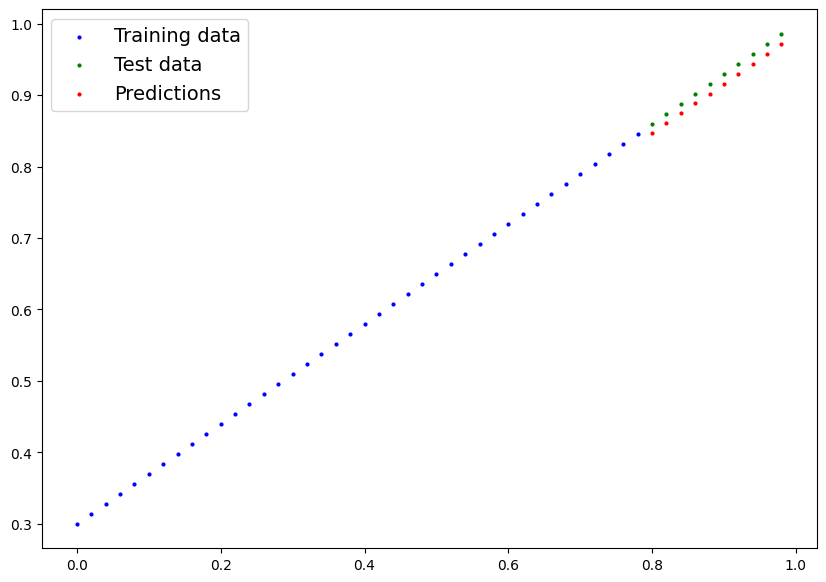

In [18]:
with torch.inference_mode():
    y_pred = model_lr(X_test)

plot_predictions(predictions=y_pred)

### Plot loss curve

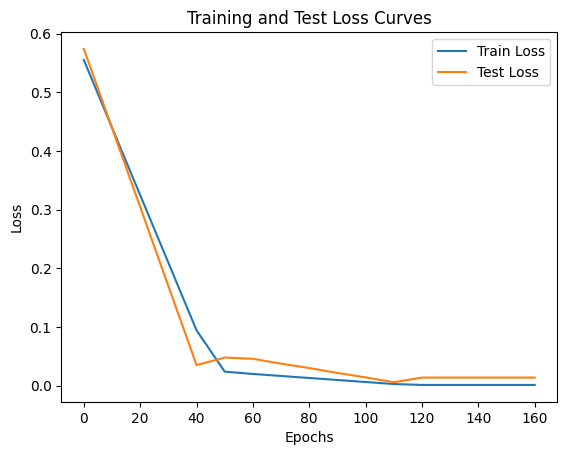

In [19]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


### Saving and Loading Models

#### Three main methods

1. &nbsp; `torch.save()`: Saves a PyTorch object in Python's pickle format
2. &nbsp; `torch.load()`: Loads a saved PyTorch object
3. &nbsp; `torch.nn.Module.load_state_dict()`: Loads a model's saved state dictionary

#### Saving

In [11]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01. Pytorch Fundamentals LR Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state_dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_lr.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models\01. Pytorch Fundamentals LR Model.pth


#### Loading

In [20]:
# 1. Instantiate a new instance of the model class
loaded_model_lr = LinearRegressionModel()

# 2. Load the saved statedict of the model
loaded_model_lr.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
model_lr.state_dict(), loaded_model_lr.state_dict()

(OrderedDict([('linear_layer.weight', tensor([[0.6929]])),
              ('linear_layer.bias', tensor([0.2925]))]),
 OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
              ('linear_layer.bias', tensor([0.3025]))]))

In [22]:
# Make predictions with loaded model
loaded_model_lr.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_lr(X_test)

loaded_model_preds, y_pred

(tensor([[0.8600],
         [0.8739],
         [0.8878],
         [0.9018],
         [0.9157],
         [0.9296],
         [0.9436],
         [0.9575],
         [0.9714],
         [0.9854]]),
 tensor([[0.8468],
         [0.8607],
         [0.8746],
         [0.8884],
         [0.9023],
         [0.9161],
         [0.9300],
         [0.9438],
         [0.9577],
         [0.9716]]))